In [1]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np
import pandas as pd
from scipy import signal
from scipy import ndimage
import time

# custom lib
from inspect import getsourcefile
import os.path as path, sys
sys.path.insert(0, "..")
from alprLib.PlateBoundingBox import PlateBoundingBox
sys.path.pop(0)

/home/ghislain/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'..'

# Load images data

#### Old dataset

In [138]:
DATASET_PATH = "../archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

In [139]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox.load_from_xml(xml_path=annotation_path)[0])

  0%|          | 0/433 [00:00<?, ?it/s]

100%|██████████| 433/433 [00:17<00:00, 24.11it/s]


#### EU dataset

In [2]:
DATASET_PATH = "../eu_dataset"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annots")
IMAGES_PATH = path.join(DATASET_PATH, "images")

In [3]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox.load_from_xml(xml_path=annotation_path)[0])

100%|██████████| 534/534 [00:12<00:00, 41.48it/s]


#### Extract random image

Image: 362


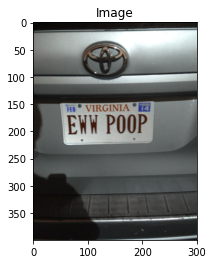

In [197]:
# Random image

random_index = rd.randint(0, len(raw_imgs) - 1)
random_index = 362

print(f"Image: {random_index}")

image = raw_imgs[random_index]
image_gray_src = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image_gray_src = np.float32(image_gray_src)

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")


Image shape: (92, 198, 3)
max value: 243.0


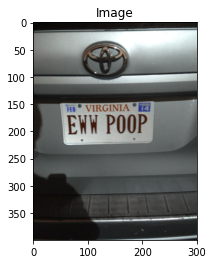

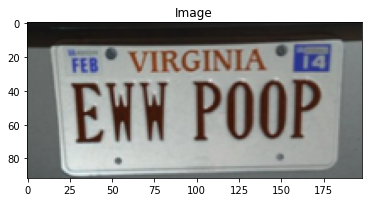

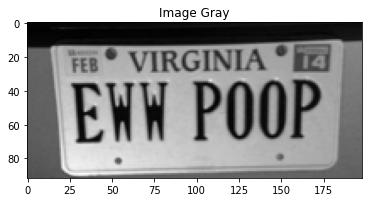

In [207]:

image = raw_imgs[random_index]
image_gray_src = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image_gray_src = np.float32(image_gray_src)

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")

padding = 15
plate = annotations[random_index]
xmin = plate.xmin-padding
ymin = plate.ymin-padding
xmax = plate.xmax+padding
ymax = plate.ymax+padding
image_gray_src = image_gray_src[ymin:ymax, xmin:xmax]
image = image[ymin:ymax, xmin:xmax]

print(f"Image shape: {image.shape}")
print(f"max value: {np.max(image_gray_src)}")

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")
plt.figure()
plt.title("Image Gray")
plt.imshow(image_gray_src, cmap="gray")


In [104]:
def kmean_segmentation(img, n_iterations = 5, n_classes = 10):
  # Initial classes centers
  max_val = np.max(img)
  min_val = np.min(img)
  interval = float(max_val-min_val)/n_classes
  classes_center = np.array([ interval/2 + min_val + interval*i for i in range(n_classes) ])

  classification = np.zeros(img.shape)
  classes_pixel_values = []
  for i in range(n_iterations):
    # Update pixel classes
    classes_pixel_values = [[] for i in range(n_classes)]
    for l in range(0, img.shape[0]):
      for c in range(0, img.shape[1]):
        dist_to_classes = np.abs(classes_center-img[l,c])
        class_index = np.argmin(dist_to_classes)
        classes_pixel_values[class_index].append(img[l,c])
        classification[l,c] = class_index

    # Update class centers
    for i in range(n_classes):
      center = np.mean(np.array(classes_pixel_values[i]))
      classes_center[i] = center

  return classification, classes_center

# Unwarping using color

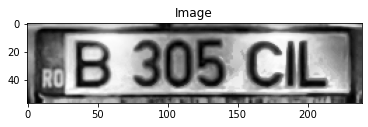

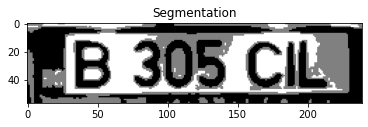

In [9]:
image_gray = image_gray_src
# Smooth the image
image_blur = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)
# Histogram equalization to has better constrast
# image_gray = cv.equalizeHist(np.uint8(image_blur))
clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(4,4))
image_gray = clahe.apply(np.uint8(image_blur))

# Classify based on color
# The brightess color is the last class
classes_count = 3
seg, _ = kmean_segmentation(image_blur, 10, classes_count)

# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 3
# Z = image.reshape((-1,3))
# Z = np.float32(Z)
# ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# seg3 = res.reshape((image.shape))

# print(seg3[23,50,0])
# print(seg3[23,50,1])
# print(seg3[23,50,2])

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,0], cmap="gray")

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,1], cmap="gray")

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,2], cmap="gray")

seg = np.uint8(seg)

plt.figure()
plt.title("Image")
plt.imshow(image_gray, cmap="gray")

plt.figure()
plt.title("Segmentation")
plt.imshow(seg, cmap="gray")


center: [ 28.5 119.5]
class 0 mean dist: 357575.11345074815
class 1 mean dist: 288342.1909567104
class 2 mean dist: 213831.22369615623


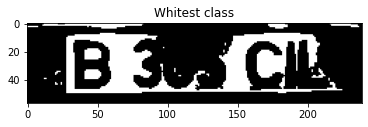

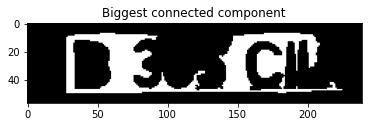

In [206]:

classes_dist = []
img_center = np.array([seg.shape[0]/2, seg.shape[1]/2])
print(f"center: {img_center}")
for i in range(classes_count):
  pixels_to_center = np.transpose(np.nonzero(seg==i)) - img_center
  pixels_to_center_dist = np.linalg.norm(pixels_to_center, axis=1)
  mean_dist = np.sum(pixels_to_center_dist)
  classes_dist.append(mean_dist)
  print(f"class {i} mean dist: { mean_dist }")

# Get the class closest to the center
seg_class = np.argmin(np.array([
  d for i, d in enumerate(classes_dist)
]))

class0 = np.uint8(1*(seg==seg_class))
# Extract connected components of that class
ret, comps = cv.connectedComponents(class0)
# Get the size of the components
colors, counts = np.unique(
  comps.reshape(-1), return_counts = True, axis = 0
  )
colors = np.delete(colors, 0) # Remove background component
counts = np.delete(counts, 0) # Remove background component
# Get the biggest component
compMax = comps==colors[np.argmax(counts)]
compMax = np.uint8(compMax)

plt.figure()
plt.title("Whitest class")
plt.imshow(class0, cmap='gray')

plt.figure()
plt.title("Biggest connected component")
# plt.imshow(comps==colors[np.argmax(counts)], cmap="gray")
plt.imshow(compMax, cmap="gray")

# We are left with a single connected 
# component that should be most parts of the plate
seg = compMax


[[ 28.   7.]
 [224.   7.]
 [224.  49.]
 [ 28.  49.]]
A:: 0


/tmp/ipykernel_8885/278153365.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)


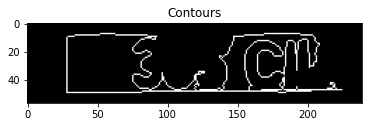

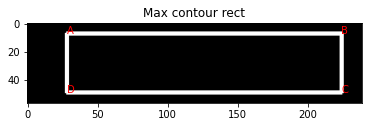

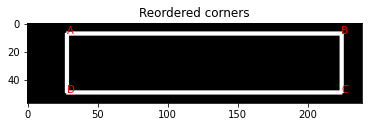

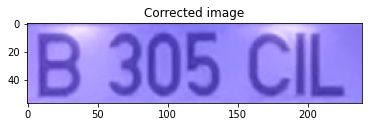

In [207]:

# Detect contours
contours, _= cv.findContours(
    seg, 
    mode=cv.RETR_EXTERNAL, # We should get a single contours for the single connected component
    method=cv.CHAIN_APPROX_SIMPLE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
max_area_contour = contours[0]
max_area = cv.contourArea(max_area_contour)
for contour in contours:
  area = cv.contourArea(contour)
  if area > max_area:
    max_area = area
    max_area_contour = contour

image_polycontours_best = np.zeros(image_gray.shape, dtype=np.uint8)
rect = cv.minAreaRect(max_area_contour)
corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)
plt.figure()
plt.title("Max contour rect")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
plt.figure()
plt.title("Reordered corners")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image.shape[0]
out_width = image.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


#### Complete pipeline test

In [216]:

def getUnwarpedPlate(imageRGB, plate_xmin, plate_ymin, plate_xmax, plate_ymax):
  image = np.copy(imageRGB)
  image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  image_gray = np.float32(image_gray)
  padding = 0
  xmin = plate_xmin-padding
  ymin = plate_ymin-padding
  xmax = plate_xmax+padding
  ymax = plate_ymax+padding
  image_gray = image_gray[ymin:ymax, xmin:xmax]
  image = image[ymin:ymax, xmin:xmax]

# Improve the image
  image_gray = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)
  # Histogram equalization for constrast optimization
  clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(4,4))
  image_gray = clahe.apply(np.uint8(image_gray))
# Segment the image by kmeans
  # The brightess color is the last class
  classes_count = 3
  seg, _ = kmean_segmentation(image_gray, 10, classes_count)
  seg = np.uint8(seg)
# Extract the class closest to white (The last class)
  classes_dist = []
  img_center = np.array([seg.shape[0]/2, seg.shape[1]/2])
  for i in range(classes_count):
    pixels_to_center = np.transpose(np.nonzero(seg==i)) - img_center
    pixels_to_center_dist = np.linalg.norm(pixels_to_center, axis=1)
    mean_dist = np.sum(pixels_to_center_dist)
    classes_dist.append(mean_dist)
  # Get the class close to the center
  seg_class = np.argmin(np.array([
    d for i, d in enumerate(classes_dist)
  ]))
  class0 = np.uint8(1*(seg==seg_class))

# Biggest connected component
  # Extract connected components of that class
  ret, comps = cv.connectedComponents(class0)
  # Get the size of the components
  colors, counts = np.unique(
    comps.reshape(-1), return_counts = True, axis = 0
    )
  colors = np.delete(colors, 0) # Remove background component
  counts = np.delete(counts, 0) # Remove background component
  # Get the biggest component
  compMax = comps==colors[np.argmax(counts)]
  compMax = np.uint8(compMax)
  # We are left with a single connected 
  # component that should be most parts of the plate

# Oriented bounding box
  # We extract the contours of the component
  contours, _= cv.findContours(
      compMax, 
      mode=cv.RETR_EXTERNAL, # We should get a single contours for the single connected component
      method=cv.CHAIN_APPROX_SIMPLE
  )
  # We get the oriented bounding box
  rect = cv.minAreaRect(contours[0])
  corners = cv.boxPoints(rect)
  # We reorder the bounding box corners  
  Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
  corners = np.array([ corners[(i+Aind)%4] for i in range(4)])

# We apply perspective correction
  out_height = image.shape[0]
  out_width = image.shape[1]
  output_size = (out_width, out_height)
  perspective_matrix = cv.getPerspectiveTransform(
    corners,
    np.array([
        [0, 0], [out_width, 0],
        [out_width, out_height], [0, out_height]
      ], dtype=np.float32)
    )
  corrected_image = cv.warpPerspective(
    image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
    )
  return corrected_image, image_gray, seg, class0


image 53: 1.3216910362243652 seconds
image 31: 0.4877285957336426 seconds
image 261: 1.272367000579834 seconds
image 128: 1.3785755634307861 seconds
image 447: 0.1624147891998291 seconds
image 490: 0.426910400390625 seconds
image 390: 2.044917583465576 seconds
image 123: 0.7605504989624023 seconds
image 304: 0.41179895401000977 seconds
image 48: 0.2116532325744629 seconds
image 45: 0.13559198379516602 seconds
image 81: 0.6054964065551758 seconds
image 58: 0.13277578353881836 seconds
image 121: 0.5642731189727783 seconds
image 232: 2.3007540702819824 seconds
image 366: 1.0618162155151367 seconds
image 208: 2.151738166809082 seconds
image 349: 0.14668488502502441 seconds
image 151: 0.18239164352416992 seconds
image 15: 0.7620768547058105 seconds


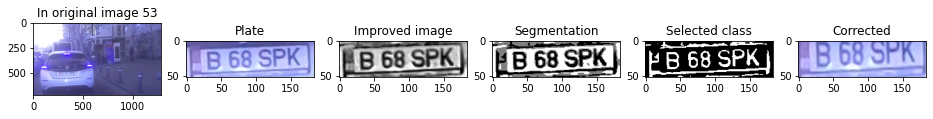

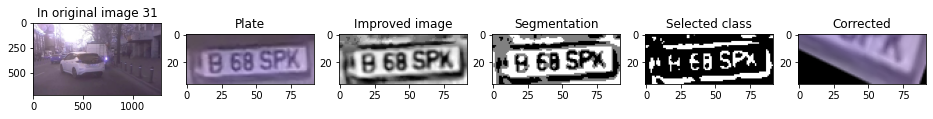

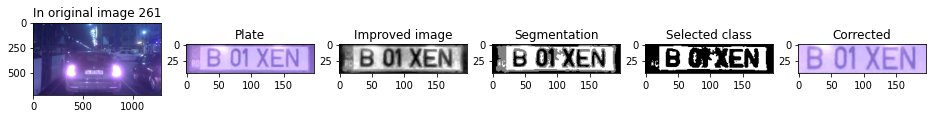

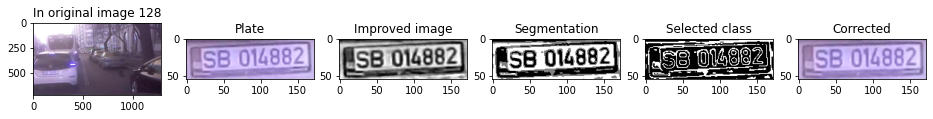

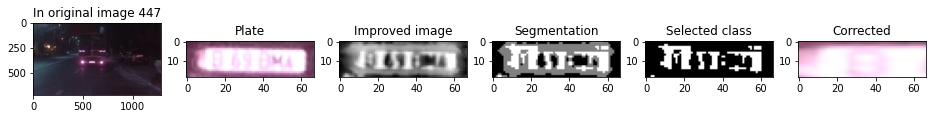

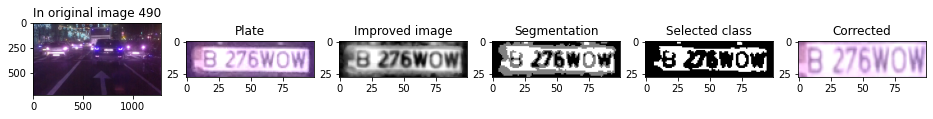

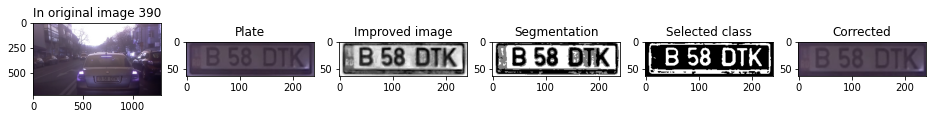

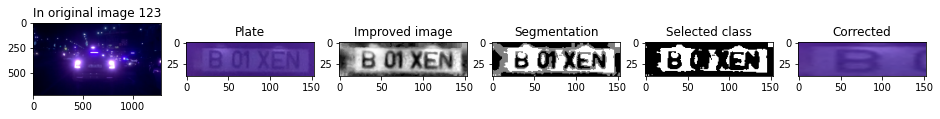

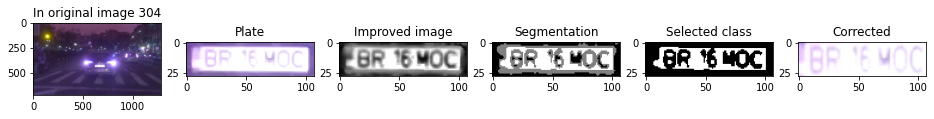

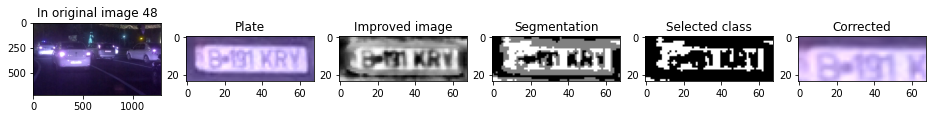

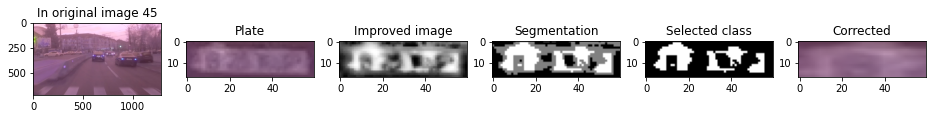

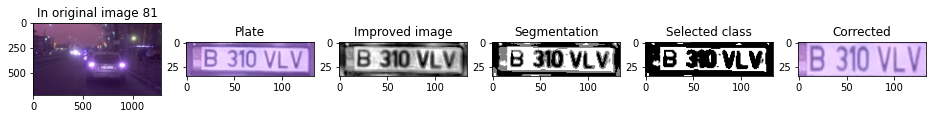

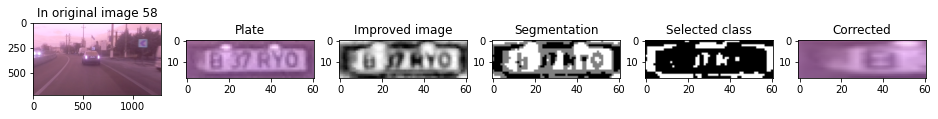

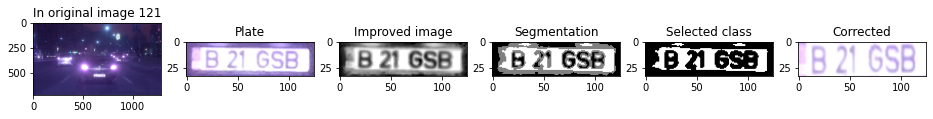

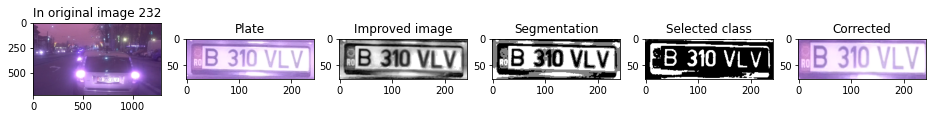

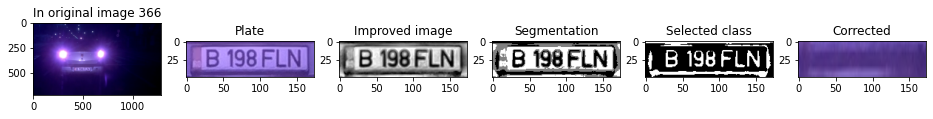

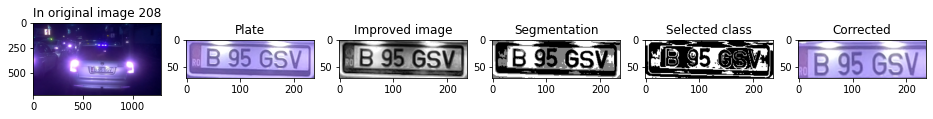

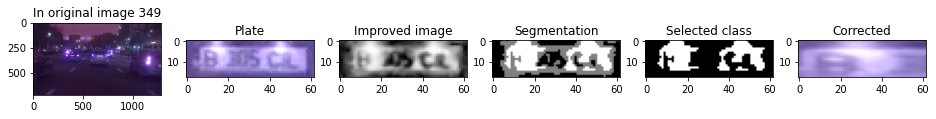

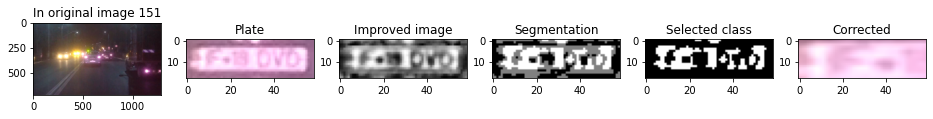

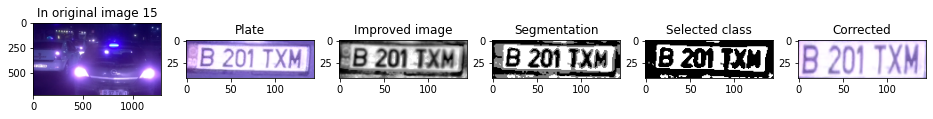

In [217]:
image_indices = rd.choices(np.arange(len(raw_imgs)), k=20)
uncorrected_images = []
corrected_images = []

images_image_gray = []
images_seg = []
images_class0 = []

anno_images = []
for index in image_indices:
  start = time.time()

  wholeimage = raw_imgs[index]
  plate = annotations[index]
  corrected, image_gray, seg, class0 = getUnwarpedPlate(wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax)

  end = time.time()
  elapsed = end - start
  print(f"image {index}: {elapsed} seconds")

  corrected_images.append(corrected)
  uncorrected_images.append(wholeimage)
  anno_images.append(plate)
  images_image_gray.append(image_gray)
  images_seg.append(seg)
  images_class0.append(class0)

for i in range(len(corrected_images)):
  plate = anno_images[i]
  fig, axisarray = plt.subplots(1, 6, figsize=(16,8))
  axisarray[0].set_title(f"In original image {image_indices[i]}")
  axisarray[0].imshow(uncorrected_images[i])
  axisarray[1].set_title('Plate')
  axisarray[1].imshow(uncorrected_images[i][plate.ymin:plate.ymax, plate.xmin:plate.xmax])

  axisarray[2].set_title('Improved image')
  axisarray[2].imshow(images_image_gray[i], cmap='gray')
  axisarray[3].set_title('Segmentation')
  axisarray[3].imshow(images_seg[i], cmap='gray')
  axisarray[4].set_title('Selected class')
  axisarray[4].imshow(images_class0[i], cmap='gray')

  axisarray[5].set_title('Corrected')
  axisarray[5].imshow(corrected_images[i])


# Method based on structure

centers: [ 66.89929802 167.42895675]


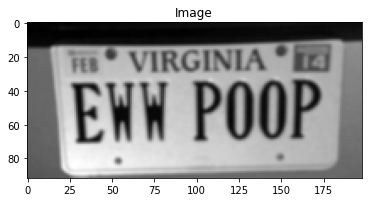

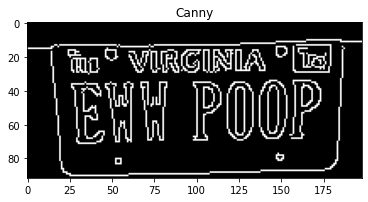

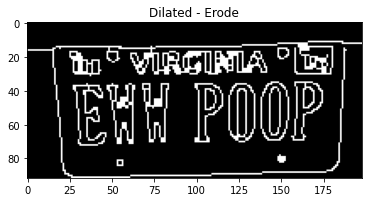

In [208]:


image_gray = cv.GaussianBlur(image_gray_src, ksize=(3, 3), sigmaX=0)
image_gray = np.uint8(image_gray)

# # Replicated borders
# top = int(0.05 * image_gray.shape[0])
# bottom = top
# left = int(0.05 * image_gray.shape[1])
# right = left
# image_gray = cv.copyMakeBorder(
#   image_gray,
#   top, bottom, left, right,
#   cv.BORDER_REPLICATE)
# image_gray = np.uint8(image_gray)

plt.figure()
plt.title("Image")
plt.imshow(image_gray, cmap="gray")

classes_count = 2
colo_seg, centers = kmean_segmentation(image_gray, 10, classes_count)

print(f"centers: {centers}")

seg = cv.Canny(image_gray,0.5*centers[0],centers[1])
plt.figure()
plt.title("Canny")
plt.imshow(seg, cmap="gray")

kernel = np.ones((2,2),np.uint8)
seg = cv.dilate(seg, kernel)
seg = cv.erode(seg, kernel)
seg = np.uint8(seg)
plt.figure()
plt.title("Dilated - Erode")
plt.imshow(seg, cmap="gray")


Best contour: [[[53 82]]

 [[54 81]]

 [[55 81]]

 [[56 82]]

 [[56 83]]

 [[55 84]]

 [[54 84]]

 [[53 83]]]
Best contour: [[[197  12]]

 [[  0  16]]

 [[ 22  89]]

 [[180  87]]

 [[188  16]]

 [[179  87]]

 [[ 27  91]]

 [[ 17  14]]

 [[112  30]]

 [[137  17]]

 [[ 76  14]]

 [[159  12]]

 [[179  30]]

 [[165  12]]]
[[-3.3367276e-02  1.4342949e+01]
 [ 1.9696730e+02  1.0376495e+01]
 [ 1.9853444e+02  8.8210709e+01]
 [ 1.5337677e+00  9.2177162e+01]]
A:: 0


/tmp/ipykernel_22981/40397705.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours,[np.int0(approx)],0,(255),2)
/tmp/ipykernel_22981/40397705.py:37: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)


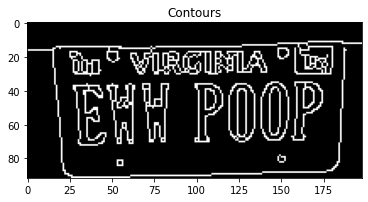

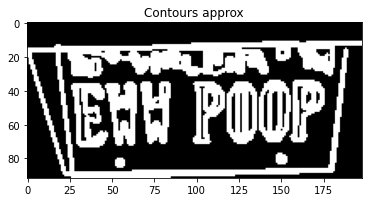

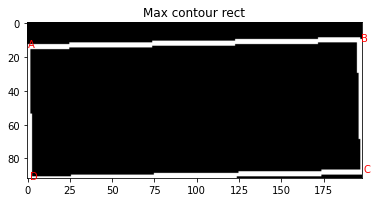

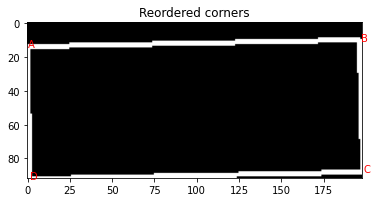

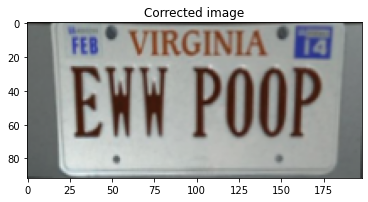

In [209]:

# Detect contours
contours, _= cv.findContours(
    seg, 
    # mode=cv.RETR_EXTERNAL,
    mode=cv.RETR_LIST,
    method=cv.CHAIN_APPROX_SIMPLE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
max_area_contour = contours[0]
max_area = 0
image_polycontours = np.zeros(image_gray.shape, dtype=np.uint8)
for contour in contours:
  # rect = cv.minAreaRect(contour)
  # corners = cv.boxPoints(rect)
  epsilon = 0.01*cv.arcLength(contour,True)
  approx = cv.approxPolyDP(contour,epsilon,True)
  weight = cv.contourArea(approx)
  cv.drawContours(image_polycontours,[np.int0(approx)],0,(255),2)
  if weight > max_area:
    print(f"Best contour: {approx}")
    max_area = area
    max_area_contour = contour
plt.figure()
plt.title("Contours approx")
plt.imshow(image_polycontours, cmap="gray")


image_polycontours_best = np.zeros(image_gray.shape, dtype=np.uint8)
rect = cv.minAreaRect(max_area_contour)
corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)
plt.figure()
plt.title("Max contour rect")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
plt.figure()
plt.title("Reordered corners")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image.shape[0]
out_width = image.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


#### Pipeline

In [194]:
def getUnwarpedPlateB(
    imageRGB, plate_xmin, plate_ymin, plate_xmax, plate_ymax,
    plate_padding = 5,
    edges_dilate_kernel_size = 2,
    contours_approximation = 0.01
  ):
  image = np.copy(imageRGB)
  image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  image_gray = np.float32(image_gray)
  xmin = plate_xmin-plate_padding
  ymin = plate_ymin-plate_padding
  xmax = plate_xmax+plate_padding
  ymax = plate_ymax+plate_padding
  image_gray = image_gray[ymin:ymax, xmin:xmax]
  image = image[ymin:ymax, xmin:xmax]
  # Blurring
  image_gray = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)
  image_gray = np.uint8(image_gray)
  # Find best hesterisis thresholding range by clustering
  classes_count = 2
  colo_seg, centers = kmean_segmentation(image_gray, 10, classes_count)
  # Canny
  seg = cv.Canny(image_gray,centers[0]*0.5,centers[1])
  # Morphological
  kernel = np.ones((edges_dilate_kernel_size,edges_dilate_kernel_size),np.uint8)
  seg = cv.dilate(seg, kernel)
  seg = cv.erode(seg, kernel)
  seg = np.uint8(seg)

  # Detect contours
  contours, _= cv.findContours(
      seg, 
      # mode=cv.RETR_EXTERNAL,
      mode=cv.RETR_LIST,
      method=cv.CHAIN_APPROX_SIMPLE
  )
  # Find biggest contour
  max_area_contour = contours[0]
  max_area = 0
  for contour in contours:
    # rect = cv.minAreaRect(contour)
    # corners = cv.boxPoints(rect)
    # area = cv.contourArea(corners)

    epsilon = contours_approximation*cv.arcLength(contour,True)
    approx = cv.approxPolyDP(contour,epsilon,True)
    area = cv.contourArea(approx)

    if area > max_area:
      max_area = area
      max_area_contour = contour
  # Get box corners
  rect = cv.minAreaRect(max_area_contour)
  corners = cv.boxPoints(rect)
  # change corners order
  Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
  corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
  # Apply warping
  out_height = image.shape[0]
  out_width = image.shape[1]
  output_size = (out_width, out_height)
  perspective_matrix = cv.getPerspectiveTransform(
    corners,
    np.array([
        [0, 0], [out_width, 0],
        [out_width, out_height], [0, out_height]
      ], dtype=np.float32)
    )
  corrected_image = cv.warpPerspective(
    image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
    )
  return corrected_image


image 263: 1.0775315761566162 seconds
image 129: 0.6460013389587402 seconds
image 209: 2.989158868789673 seconds
image 83: 1.4676895141601562 seconds
image 381: 0.8899493217468262 seconds
image 343: 0.2578613758087158 seconds
image 212: 0.11301183700561523 seconds
image 302: 0.9337403774261475 seconds
image 362: 1.8198354244232178 seconds
image 16: 1.087522029876709 seconds
image 330: 0.4216189384460449 seconds
image 163: 3.3695924282073975 seconds
image 207: 0.5642580986022949 seconds
image 338: 0.5500597953796387 seconds
image 191: 0.3000068664550781 seconds
image 276: 0.2893996238708496 seconds
image 27: 0.15977001190185547 seconds
image 191: 0.32006263732910156 seconds
image 148: 0.534548282623291 seconds
image 346: 0.5911476612091064 seconds


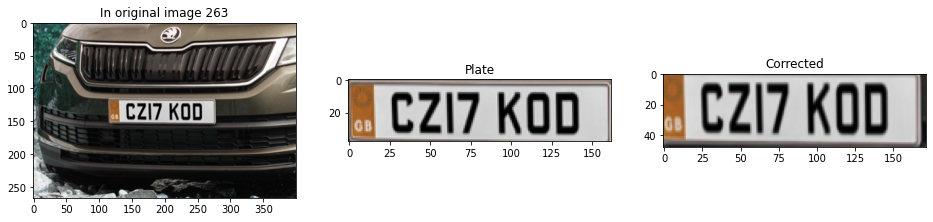

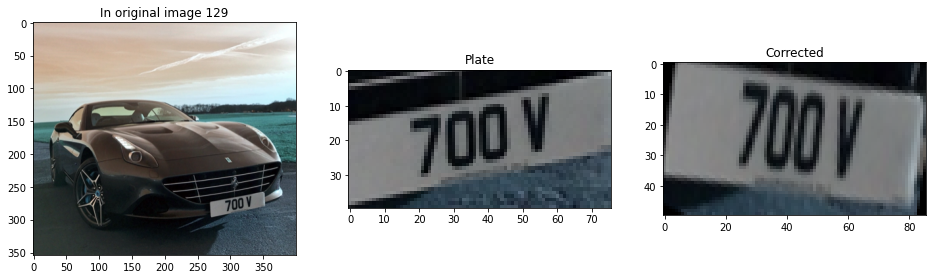

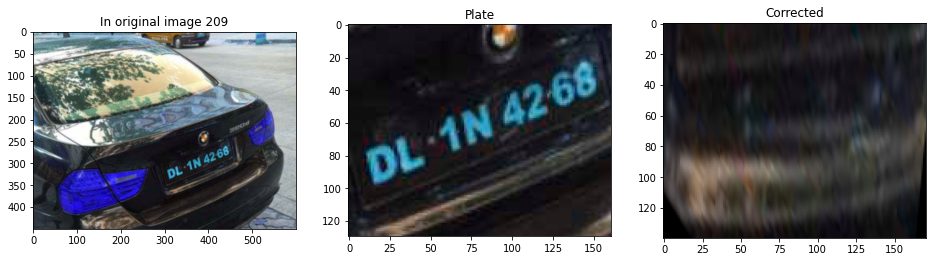

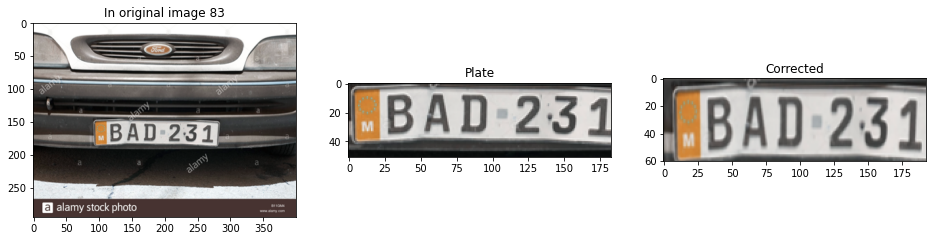

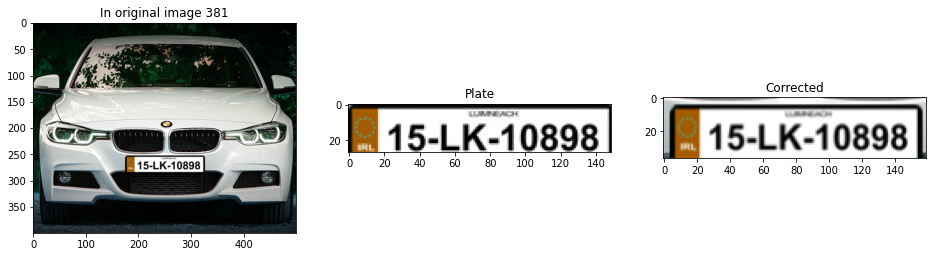

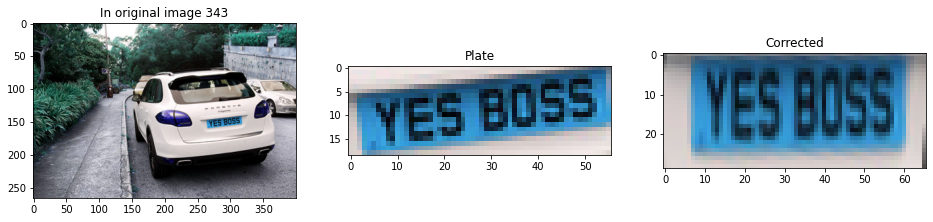

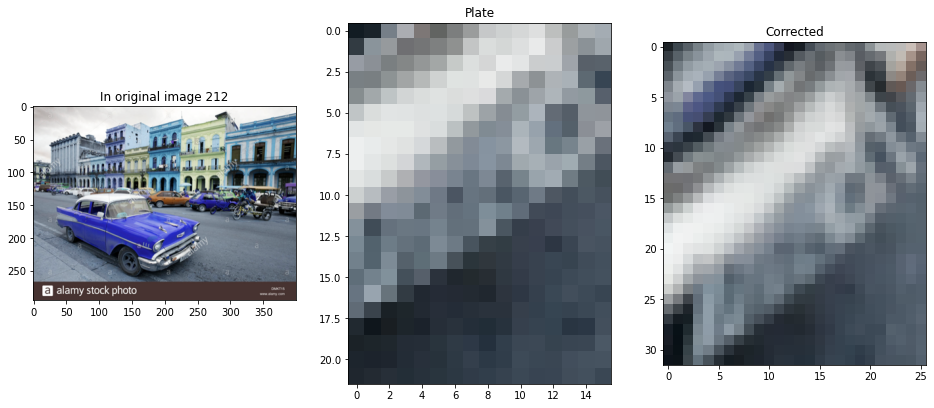

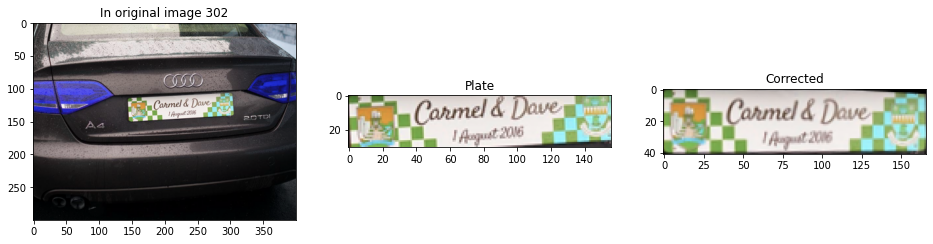

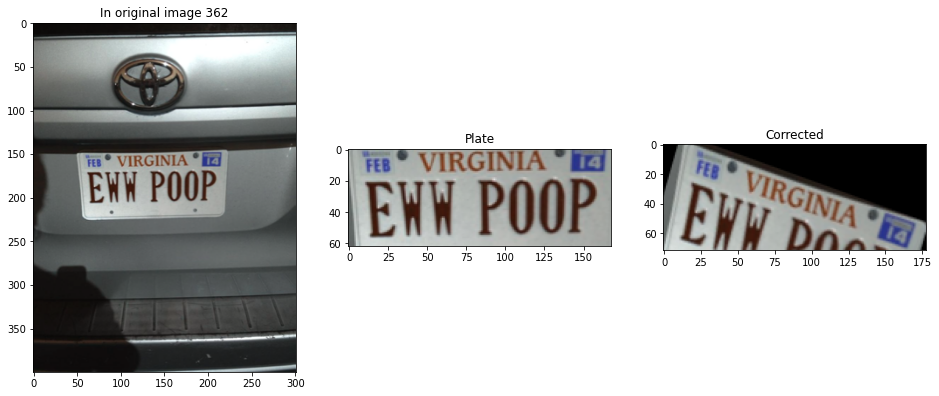

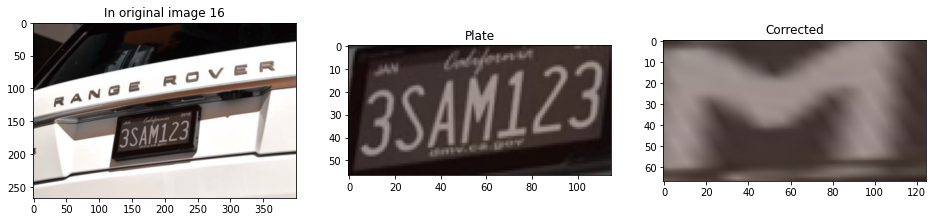

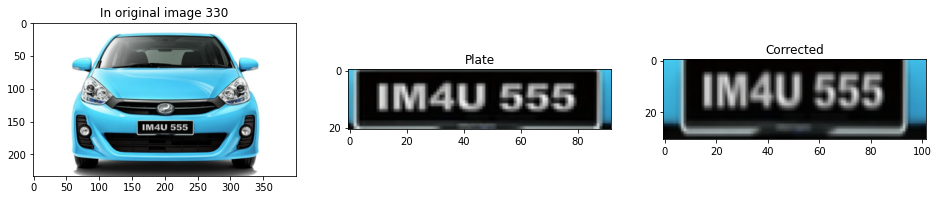

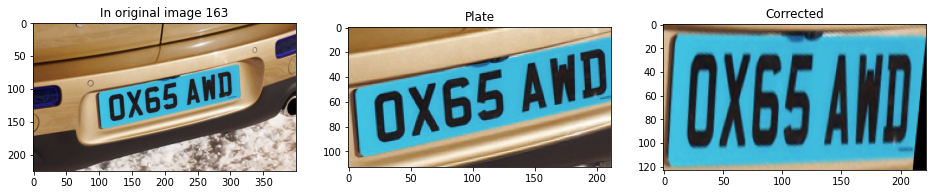

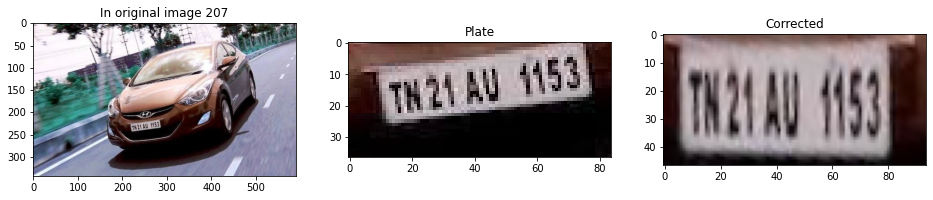

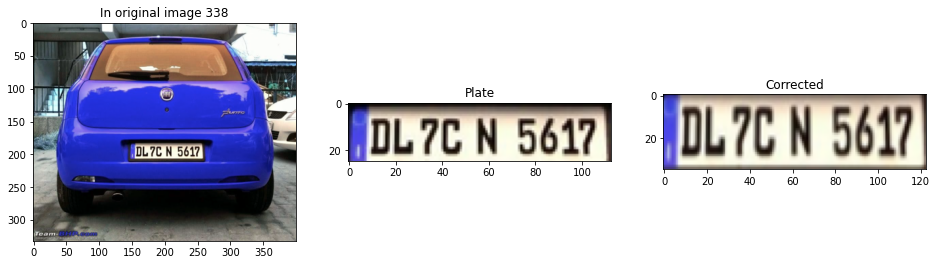

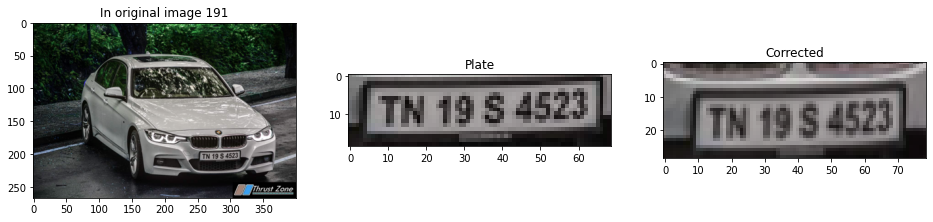

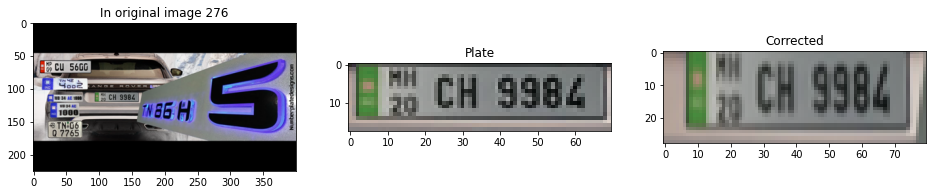

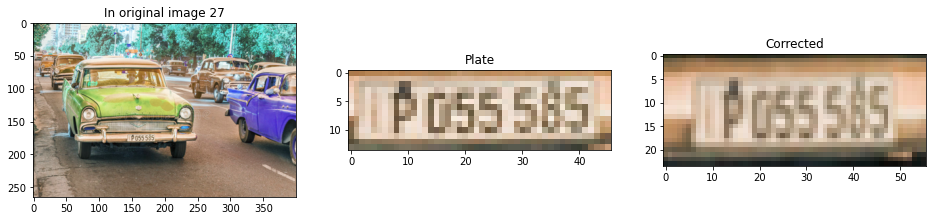

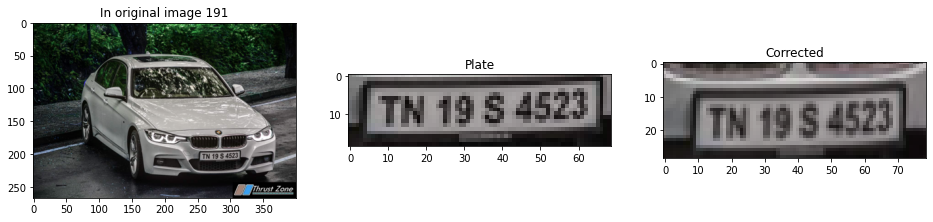

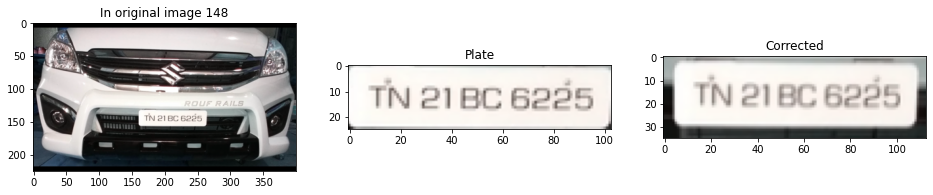

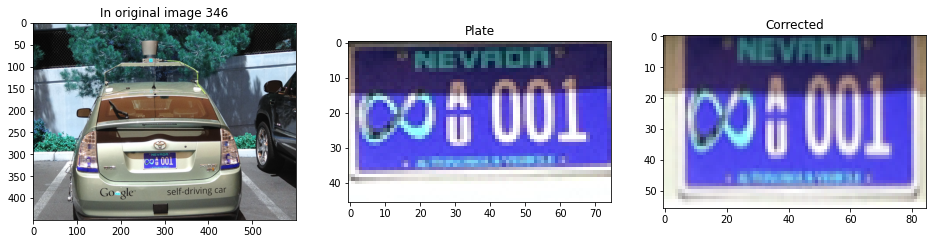

In [196]:
image_indices = rd.choices(np.arange(len(raw_imgs)), k=20)
uncorrected_images = []
corrected_images = []

anno_images = []
for index in image_indices:
  start = time.time()

  wholeimage = raw_imgs[index]
  plate = annotations[index]
  corrected = getUnwarpedPlateB(wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax)

  end = time.time()
  elapsed = end - start
  print(f"image {index}: {elapsed} seconds")

  corrected_images.append(corrected)
  uncorrected_images.append(wholeimage)
  anno_images.append(plate)

for i in range(len(corrected_images)):
  plate = anno_images[i]
  fig, axisarray = plt.subplots(1, 3, figsize=(16,8))
  axisarray[0].set_title(f"In original image {image_indices[i]}")
  axisarray[0].imshow(uncorrected_images[i])
  axisarray[1].set_title('Plate')
  axisarray[1].imshow(uncorrected_images[i][plate.ymin:plate.ymax, plate.xmin:plate.xmax])
  axisarray[2].set_title('Corrected')
  axisarray[2].imshow(corrected_images[i])
